In [43]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/mwitiderrick/stockprice/master/NSE-TATAGLOBAL.csv')
df = df.dropna()
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [4]:
df.tail()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


In [5]:
df_close = df['Close']

In [6]:
df_close.shape

(2035,)

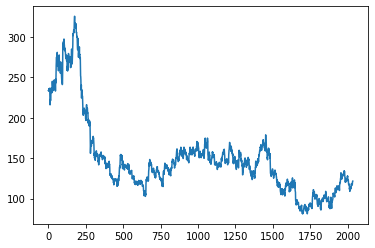

In [7]:
plt.plot(df_close)

In [8]:
scaler = MinMaxScaler(feature_range = (0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [9]:
df_close.shape

(2035, 1)

In [10]:
df_close

array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [13]:
training_size = int(len(df_close) * 0.75)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]


In [14]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [16]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [17]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [38]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs =100 , batch_size = 64, verbose = 1)

Epoch 1/100
23/23 [==============================] - 10s 433ms/step - loss: 8.2541e-04 - val_loss: 0.0010
Epoch 2/100
23/23 [==============================] - 9s 383ms/step - loss: 8.4196e-04 - val_loss: 8.4990e-04
Epoch 3/100
23/23 [==============================] - 9s 384ms/step - loss: 7.5234e-04 - val_loss: 8.4368e-04
Epoch 4/100
23/23 [==============================] - 9s 407ms/step - loss: 7.6480e-04 - val_loss: 6.8042e-04
Epoch 5/100
23/23 [==============================] - 8s 354ms/step - loss: 7.3975e-04 - val_loss: 6.8125e-04
Epoch 6/100
23/23 [==============================] - 9s 372ms/step - loss: 7.3163e-04 - val_loss: 6.2798e-04
Epoch 7/100
23/23 [==============================] - 9s 407ms/step - loss: 7.8732e-04 - val_loss: 9.2242e-04
Epoch 8/100
23/23 [==============================] - 9s 397ms/step - loss: 6.7786e-04 - val_loss: 7.6636e-04
Epoch 9/100
23/23 [==============================] - 13s 590ms/step - loss: 6.9243e-04 - val_loss: 6.2235e-04
Epoch 10/100
23/23 [=

In [20]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [21]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [24]:
math.sqrt(mean_squared_error(y_train, train_predict))

158.40433344330006

In [25]:
math.sqrt(mean_squared_error(y_test, test_predict))

107.31489816353849

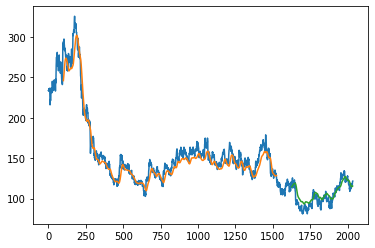

In [26]:

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [27]:
#Predict the next 30 days Stock Price
len(test_data), x_test.shape

(509, (408, 100, 1))

In [28]:
x_input = test_data[207:].reshape(1,-1)
x_input.shape

(1, 302)

In [29]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [39]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

while(i<nextNumberOfDays):
    
    if(len(temp_input)>100):
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

0 day input [0.01940359 0.02246732 0.03125    0.02348856 0.0249183  0.02144608
 0.04840686 0.04575163 0.03962418 0.03921569 0.04758987 0.04513889
 0.04166667 0.04125817 0.05044935 0.05555556 0.05494281 0.05412582
 0.0435049  0.04799837 0.05147059 0.05065359 0.03431373 0.04575163
 0.04187092 0.04554739 0.03941993 0.02716503 0.03125    0.05882353
 0.07148693 0.08721405 0.08986928 0.10498366 0.08905229 0.10355392
 0.10375817 0.12275327 0.10906863 0.09660948 0.1064134  0.10457516
 0.11049837 0.1127451  0.09803922 0.09987745 0.08925654 0.0747549
 0.08169935 0.08925654 0.09068627 0.08129085 0.08823529 0.08455882
 0.07945261 0.08374183 0.07781863 0.09824346 0.09089052 0.09007353
 0.09558824 0.06862745 0.06372549 0.0494281  0.04799837 0.04534314
 0.0443219  0.03941993 0.0379902  0.04656863 0.05085784 0.07209967
 0.06535948 0.07230392 0.07802288 0.07741013 0.06086601 0.06413399
 0.07046569 0.05412582 0.0498366  0.05167484 0.05330882 0.0435049
 0.02634804 0.02410131 0.02961601 0.01960784 0.02961

ValueError: cannot reshape array of size 301 into shape (1,100,1)

In [34]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [35]:
df3 = df_close.tolist()
df3.extend(lst_output)

In [41]:
len(df_close)

2035

ValueError: x and y must have same first dimension, but have shapes (100,) and (907, 1)

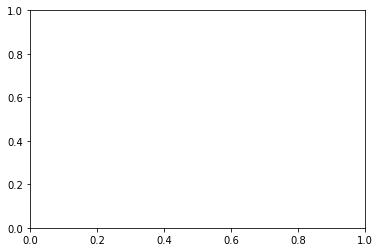

In [42]:
plt.plot(day_new, scaler.inverse_transform(df_close[1128:]))
plt.plot(day_pred, scaler.inverse_transform(lst_output))